<a href="https://colab.research.google.com/github/gourav10/autoencoder_embedding/blob/main/triplet_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Gopal Krishna, Goura Beura, Heet Sakaria
Date: 12/15/22
CS 7180


# General Imports and Model definations

In [46]:
from google.colab import drive
import os

In [47]:
import pandas as pd
import numpy as np
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [48]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [50]:
%cd /content/gdrive/MyDrive/CS7180

/content/gdrive/MyDrive/CS7180


## Data Prep. for Encoder Training using Triplet Loss

In [51]:
train_df = pd.read_csv('/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/mnist_train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/mnist_test.csv')

In [52]:
torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [53]:
train_df.head()

5  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.608  0.609  0.610  \
0  0  0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  4  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  1  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  9  0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  2  0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.611  0.612  0.613  0.614  0.615  0.616  0.617  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]

In [54]:
train_df.rename(columns={'5':'label'},inplace=True)

In [55]:
test_df.rename(columns={'7':'label'},inplace=True)

In [56]:
test_df.head()

label  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.658  0.659  0.660  \
0      2  0    0    0    0    0    0    0    0    0  ...      0      0      0   
1      1  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2      0  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3      4  0    0    0    0    0    0    0    0    0  ...      0      0      0   
4      1  0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.661  0.662  0.663  0.664  0.665  0.666  0.667  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]

## Define Triplet Dataset

In [57]:
class Triplet_MNIST(Dataset):
    def __init__(self, df, is_train=True,transform = None):
        self.is_train = is_train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:
            self.images = df.iloc[:,1:].values.astype(np.uint8)
            self.labels = df.iloc[:,0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        anchor_img = self.images[index].reshape(28,28,1)
        
        if self.is_train:
            anchor_label = self.labels[index]
            
            positive_list = self.index[self.index!=index][self.labels[self.index!=index]==anchor_label]
            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28,28,1)
            
            negative_list = self.index[self.index!=index][self.labels[self.index!=index]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

In [58]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

In [59]:
batch_size = 32
epochs = 50

In [60]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
from torchvision import datasets

# Define Model

In [61]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,
                 fc2_input_dim,
                 in_channels=1) -> None:
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            # 1st convolutional layer
            nn.Conv2d(in_channels, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            # 2nd Convolutional Layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # 3rd Convolutional Layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_linear = nn.Sequential(
            nn.Linear(3*3*32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_linear(x)
        return x


class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, out_channels=1) -> None:
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3*3*32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        # Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the
        # output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x


## Helper Methods

In [62]:
def generate_embeddings(encoder, test_data, device):
  encoded_samples = []
  for sample in tqdm(test_data):
      img = sample[0].unsqueeze(0).to(device)
      label = sample[1]
      # Encode image
      encoder.eval()
      with torch.no_grad():
          encoded_img  = encoder(img)
      # Append to list
      encoded_img = encoded_img.flatten().cpu().numpy()
      encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
      encoded_sample['label'] = label
      encoded_samples.append(encoded_sample)
  return encoded_samples

In [63]:
def visualize_embeddings_2D(x_values, y_values, labels, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.title(experiment_name)
    plt.show()

In [64]:
def save_model(model, model_name=''):
    os.makedirs('temp', exist_ok=True)
    dest_path_encoder = os.path.join('temp', f'{model_name}.pt')
    torch.jit.save(model, dest_path_encoder)

In [65]:
def visualize_clustering_2D(x_values, y_values, labels, centers, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    plt.title(experiment_name)
    plt.show()

In [66]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)
    return km

In [67]:
def visualize_clustering_2D(x_values, y_values, labels, centers, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    plt.title(experiment_name)
    plt.show()

## Training and Validation

In [68]:
def __train( encoder, decoder, train_loader, criterion_encoder, criterion_decoder, optimizer):
  encoder.train()
  decoder.train()
  train_loss = []
  for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
      anchor_img = anchor_img.to(device)
      positive_img = positive_img.to(device)
      negative_img = negative_img.to(device)
      
      optimizer.zero_grad()
      anchor_out = encoder(anchor_img)
      positive_out = encoder(positive_img)
      negative_out = encoder(negative_img)
      
      decoded_data = decoder(anchor_out)
      loss_encoder = criterion_encoder(anchor_out, positive_out, negative_out)

      loss_decoder = criterion_decoder(decoded_data, anchor_img)
      
      loss = loss_encoder+loss_decoder
      loss.backward()

      optimizer.step()
      

      train_loss.append(loss.detach().cpu().numpy())
  return np.mean(train_loss)


In [69]:
def __validate( encoder, decoder, val_loader, criterion_encoder, criterion_decoder, optimizer):
  encoder.eval()
  decoder.eval()
  val_loss = []
  with torch.no_grad():
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(val_loader, desc="Validating", leave=False)):
      anchor_img = anchor_img.to(device)
      positive_img = positive_img.to(device)
      negative_img = negative_img.to(device)
      
      # optimizer.zero_grad()
      anchor_out = encoder(anchor_img)
      positive_out = encoder(positive_img)
      negative_out = encoder(negative_img)
      
      decoded_data = decoder(anchor_out)

      loss_encoder = criterion_encoder(anchor_out, positive_out, negative_out)
      loss_decoder = criterion_decoder(decoded_data, anchor_img)
      
      loss = loss_encoder+loss_decoder
      val_loss.append(loss.detach().cpu().numpy())

    return np.mean(val_loss)

In [78]:
def model_fit(encoder, decoder,
              train_dl,
              val_loader,
              criterion_encoder,
              criterion_decoder,
              optimizer,
              device,
              num_epochs,
              exp_name = ""):
  encoder = encoder.to(device)
  decoder = decoder.to(device)
  history = {'train_loss': [], 'val_loss': []}
  min_loss = float('inf')
  for epoch in tqdm(range(num_epochs), desc="Epochs"):
      train_loss = __train(encoder, decoder, train_loader, criterion_encoder, criterion_decoder, optimizer)
      # val_loss = __validate(encoder, decoder, val_loader, criterion_encoder, criterion_decoder, optimizer)

      if (epoch % 5 == 0):
          # print('\n EPOCH {}/{} \t train loss{:.3f} \t val loss {:.3f}'
          #       .format(epoch + 1, num_epochs,
          #               train_loss, val_loss))
          print('\n EPOCH {}/{} \t train loss{:.3f}'
                .format(epoch + 1, num_epochs,
                        train_loss))

      if (epoch % 10 == 0):
          save_model(encoder,model_name=f'model_encoder_{epoch}')
          save_model(decoder,model_name=f'model_decoder_{epoch}')

      if (min_loss > train_loss):
          min_loss = train_loss
          save_model(encoder,model_name=f'best_encoder_{exp_name}')
          save_model(decoder,model_name=f'best_decoder_{epoch}')

      history['train_loss'].append(train_loss)
      # history['val_loss'].append(val_loss)
  return history

# Model 1: Autoencoder with latent space dimension 4 (Old)

In [26]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Train Encoder: Using Triplet Loss

In [27]:
model = Encoder(encoded_space_dim=4,fc2_input_dim=128)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = torch.jit.script(torch.nn.TripletMarginLoss())

In [28]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1/50 - Loss: 0.1099


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2/50 - Loss: 0.0375


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3/50 - Loss: 0.0294


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4/50 - Loss: 0.0243


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5/50 - Loss: 0.0223


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6/50 - Loss: 0.0183


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7/50 - Loss: 0.0172


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8/50 - Loss: 0.0171


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9/50 - Loss: 0.0168


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10/50 - Loss: 0.0144


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 11/50 - Loss: 0.0138


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 12/50 - Loss: 0.0135


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 13/50 - Loss: 0.0120


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 14/50 - Loss: 0.0115


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 15/50 - Loss: 0.0131


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 16/50 - Loss: 0.0109


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 17/50 - Loss: 0.0113


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 18/50 - Loss: 0.0113


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 19/50 - Loss: 0.0101


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 20/50 - Loss: 0.0099


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 21/50 - Loss: 0.0100


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 22/50 - Loss: 0.0093


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 23/50 - Loss: 0.0093


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 24/50 - Loss: 0.0095


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 25/50 - Loss: 0.0076


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 26/50 - Loss: 0.0086


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 27/50 - Loss: 0.0082


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 28/50 - Loss: 0.0081


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 29/50 - Loss: 0.0077


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 30/50 - Loss: 0.0077


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 31/50 - Loss: 0.0084


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 32/50 - Loss: 0.0072


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 33/50 - Loss: 0.0078


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 34/50 - Loss: 0.0070


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 35/50 - Loss: 0.0078


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 36/50 - Loss: 0.0070


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 37/50 - Loss: 0.0067


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 38/50 - Loss: 0.0079


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 39/50 - Loss: 0.0057


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 40/50 - Loss: 0.0064


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 41/50 - Loss: 0.0060


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 42/50 - Loss: 0.0069


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 43/50 - Loss: 0.0067


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 44/50 - Loss: 0.0053


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 45/50 - Loss: 0.0055


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 46/50 - Loss: 0.0066


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 47/50 - Loss: 0.0061


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 48/50 - Loss: 0.0063


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 49/50 - Loss: 0.0056


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 50/50 - Loss: 0.0062


In [29]:
%cd '/content/gdrive/MyDrive/CS7180/autoencoder_embedding/'

/content/gdrive/MyDrive/CS7180/autoencoder_embedding


In [30]:
!pwd

/content/gdrive/MyDrive/CS7180/autoencoder_embedding


In [31]:
save_model(model, 'encoder_embd4')

## Train Decoder: Using MSE Loss

In [32]:
DATA_DIR = '/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST'

In [33]:
import os
os.makedirs(DATA_DIR,exist_ok=True)

In [34]:
train_data = datasets.MNIST(root=DATA_DIR, train=True, download=True)
test_data = datasets.MNIST(root=DATA_DIR, train=False, download=True)

In [35]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4)

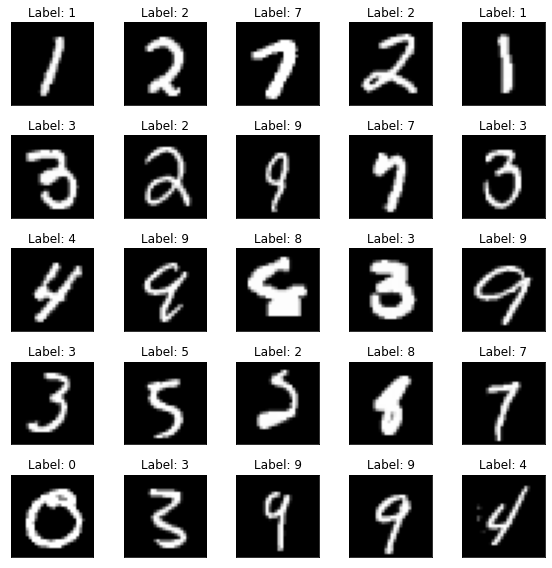

In [36]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_data)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [37]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [38]:
m=len(train_data)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_data, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

In [39]:
decoder = Decoder(encoded_space_dim=4)

In [40]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': model.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [41]:
def __train(dataloader, loss_fn, optimizer,encoder,decoder):
    encoder.eval()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [42]:
def __validate(dataloader, loss_fn, encoder, decoder):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.item()

In [43]:
def train_model(model_name, train_dl,
                test_dl, loss_fn, optimizer,
                encoder, decoder, device, num_epochs):
    # encoder = encoder.to(device)
    history = {}
    encoder = torch.jit.script(encoder).to(device)
    # decoder = decoder.to(device)
    decoder = torch.jit.script(decoder).to(device)
    loss_fn = torch.jit.script(loss_fn)
    history = {'train_loss': [], 'val_loss': []}
    min_loss = float('inf')
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        train_loss = __train(train_dl, loss_fn, optimizer,encoder,decoder)
        val_loss = __validate(test_dl, loss_fn,encoder,decoder)

        if (epoch % 5 == 0):
            print('\n EPOCH {}/{} \t train loss{:.3f} \t val loss {:.3f}'
                  .format(epoch + 1, num_epochs,
                          train_loss, val_loss))

        if (epoch % 10 == 0):
            save_model(decoder, model_name=f'model_{model_name}_{epoch}')

        if (min_loss > val_loss):
            min_loss = val_loss
            save_model(decoder, model_name=f'best_{model_name}')

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
    return history

In [44]:
history = train_model("decoder",
                      train_loader,
                      valid_loader,
                      loss_fn,
                      optim,
                      model,
                      decoder,
                      device,
                      epochs)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]


 EPOCH 1/50 	 train loss0.103 	 val loss 0.062

 EPOCH 6/50 	 train loss0.040 	 val loss 0.039

 EPOCH 11/50 	 train loss0.031 	 val loss 0.031

 EPOCH 16/50 	 train loss0.027 	 val loss 0.027

 EPOCH 21/50 	 train loss0.026 	 val loss 0.027

 EPOCH 26/50 	 train loss0.025 	 val loss 0.026

 EPOCH 31/50 	 train loss0.025 	 val loss 0.026

 EPOCH 36/50 	 train loss0.025 	 val loss 0.026

 EPOCH 41/50 	 train loss0.025 	 val loss 0.026

 EPOCH 46/50 	 train loss0.025 	 val loss 0.025


In [45]:
def plot_train_loss(history, title=""):
    plt.figure(figsize=(10, 8))
    plt.semilogy(history['train_loss'], label='Train')
    plt.semilogy(history['val_loss'], label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend(history.keys())
    plt.title(title)
    plt.show()

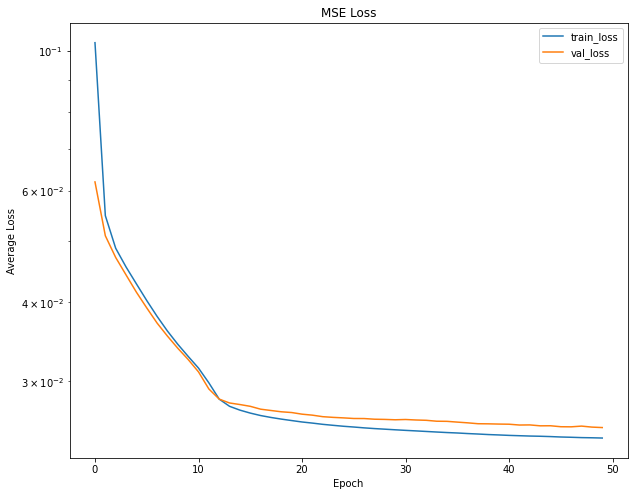

In [46]:
plot_train_loss(history,"MSE Loss")

## Generate Latent Space Embeddings

In [80]:
encoded_samples = generate_embeddings(model, test_data, device)
encoded_samples = pd.DataFrame(encoded_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [48]:
encoded_samples.head()

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  label
0         0.255466         0.246003        -0.604791        -0.887439      7
1        -0.181641         1.206252        -0.786766         0.195878      2
2         0.388201         0.451814        -1.551738         0.328492      1
3        -0.124182        -0.288751         0.465556         0.337240      0
4         0.556521        -0.992656        -0.366026        -0.284616      4

In [49]:
def visualize_embeddings_2D(x_values, y_values, labels, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.title(experiment_name)
    plt.show()

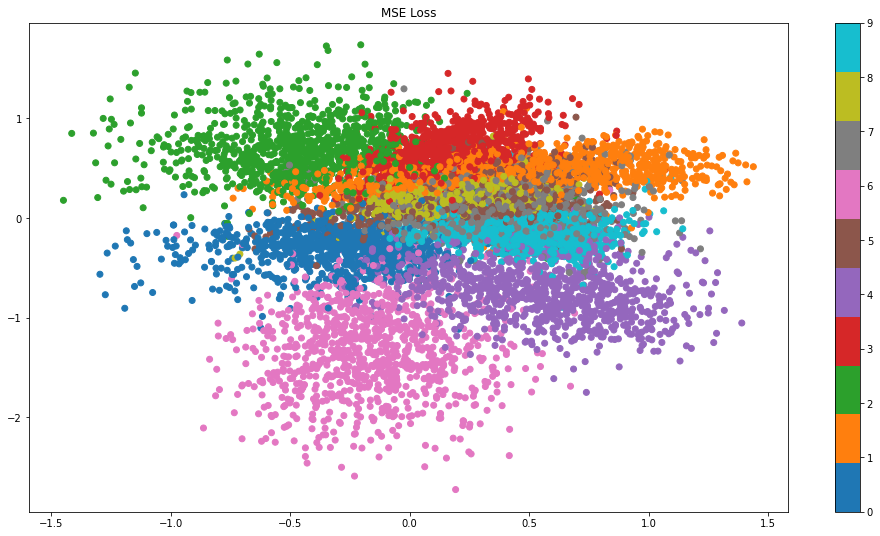

In [50]:
visualize_embeddings_2D(encoded_samples['Enc. Variable 0'], 
                        encoded_samples['Enc. Variable 1'],
                        encoded_samples.label, "MSE Loss")

## Reduce Dimension

In [51]:
def cluster_latent_space(clustering_model, embedding_df, experiment_name):
    clustering_results = clustering_model.fit_transform(
        embedding_df.drop(["label"], axis=1)
    )
    visualize_embeddings_2D(
        clustering_results[:, 0], clustering_results[:, 1], embedding_df.label,
        experiment_name
    )
    return clustering_results

In [52]:
from sklearn.manifold import TSNE

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


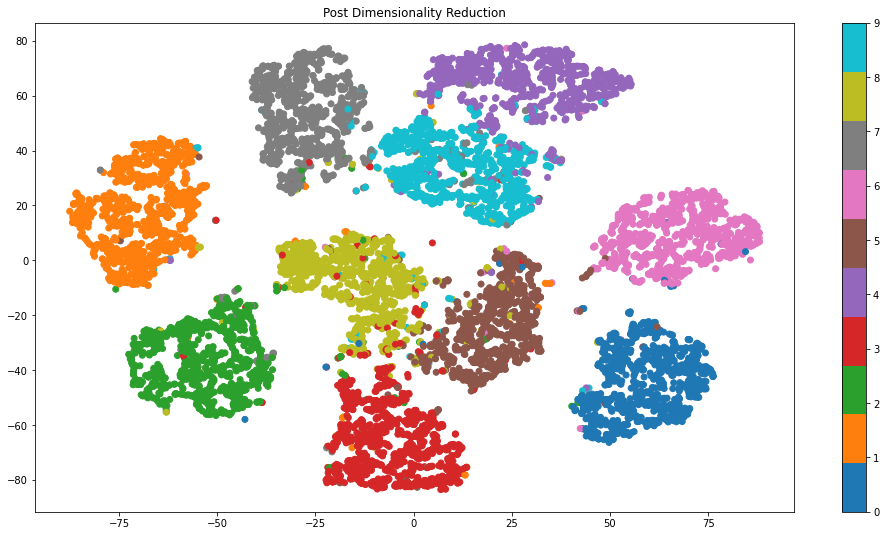

In [53]:
%time
tsne = TSNE(n_components=2,init = 'pca')
clustering_results = cluster_latent_space(tsne, encoded_samples, "Post Dimensionality Reduction")

In [54]:
clustering_results
dftsne = pd.DataFrame(clustering_results)

In [55]:
dftsne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float32
 1   1       10000 non-null  float32
dtypes: float32(2)
memory usage: 78.2 KB


In [56]:
len(encoded_samples.label)
dftsne['cluster'] = encoded_samples.label

In [57]:
dftsne.head()

0          1  cluster
0 -33.059414  63.281635        7
1 -72.217903 -34.830650        2
2 -84.297531  13.347897        1
3  59.243824 -34.430180        0
4  39.707924  58.123375        4

In [58]:
dftsne.columns

Index([0, 1, 'cluster'], dtype='object')

In [59]:
dftsne[0]

0      -33.059414
1      -72.217903
2      -84.297531
3       59.243824
4       39.707924
          ...    
9995   -43.508789
9996     2.040337
9997    14.387500
9998    22.342037
9999    67.931847
Name: 0, Length: 10000, dtype: float32

In [60]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
kmeans = fit_and_evaluate(kmeans, dftsne, dftsne['cluster'], name="KMeans with Embedding 4", n_runs=5)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

clustering done in 0.28 ± 0.02 s 
Homogeneity: 0.879 ± 0.000
Completeness: 0.879 ± 0.000
V-measure: 0.879 ± 0.000
Adjusted Rand-Index: 0.882 ± 0.000
Silhouette Coefficient: 0.542 ± 0.005


# Model 1: Autoencoder with latent space dimension 4

In [79]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [80]:
encoder = Encoder(encoded_space_dim=4,fc2_input_dim=128)
encoder = torch.jit.script(encoder).to(device)

decoder = Decoder(encoded_space_dim=4)
decoder = torch.jit.script(decoder).to(device)

In [81]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)

criterion_encoder = torch.jit.script(torch.nn.TripletMarginLoss())
criterion_decoder = torch.jit.script(torch.nn.MSELoss())

In [82]:
from sklearn.model_selection import train_test_split
test_df.info()
test_exp_df, val_exp_df = train_test_split(test_df, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Columns: 785 entries, label to 0.667
dtypes: int64(785)
memory usage: 59.9 MB


In [83]:
batch_size = 32
epochs = 50

In [84]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
val_ds = Triplet_MNIST(val_exp_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

test_ds = Triplet_MNIST(test_exp_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

# m=len(train_ds)
# train_data = train_ds[:int(m-m*0.2)]
# val_data = train_ds[int(m-m*0.2):]

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds,batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
history = model_fit(encoder, decoder, train_loader, val_loader, 
                    criterion_encoder, criterion_decoder,optimizer, 
                    device,epochs, "embed4")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 1/50 	 train loss0.172


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 6/50 	 train loss0.062


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 11/50 	 train loss0.053


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 16/50 	 train loss0.049


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 21/50 	 train loss0.047


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18737af1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18737af1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Training:   0%|          | 0/1875 [00:00<?, ?it/s]


 EPOCH 26/50 	 train loss0.044


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

# Model 2: Autoencoder with latent space dimension 5

## Initialize Autoencoder

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [61]:
encoder = Encoder(encoded_space_dim=5,fc2_input_dim=128)
encoder = torch.jit.script(encoder).to(device)

decoder = Decoder(encoded_space_dim=5)
decoder = torch.jit.script(decoder).to(device)

In [63]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)

criterion_encoder = torch.jit.script(torch.nn.TripletMarginLoss())
criterion_decoder = torch.jit.script(torch.nn.MSELoss())

In [31]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
test_ds = Triplet_MNIST(test_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model Training

In [66]:
encoder.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = {'mse':[],
                    'triplet':[]
                   }
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = encoder(anchor_img)
        positive_out = encoder(positive_img)
        negative_out = encoder(negative_img)
        
        decoded_data = decoder(anchor_out)
        loss_encoder = criterion_encoder(anchor_out, positive_out, negative_out)

        loss_decoder = criterion_decoder(decoded_data, anchor_img)
        
        loss = loss_encoder+loss_decoder
        loss.backward()

        optimizer.step()
        
        running_loss['triplet'].append(loss.cpu().detach().numpy())
        running_loss['mse'].append(loss_decoder.cpu().detach().numpy())
    print("Epoch: {}/{} - Triplet Loss: {:.4f} - MSE Loss: {:.4f}".format(epoch+1, epochs, np.mean(np.array(running_loss['triplet'])),np.mean(np.array(running_loss['mse']))))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 1/50 - Triplet Loss: 0.3645 - MSE Loss: 0.1564


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 2/50 - Triplet Loss: 0.1128 - MSE Loss: 0.0591


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 3/50 - Triplet Loss: 0.0839 - MSE Loss: 0.0492


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 4/50 - Triplet Loss: 0.0734 - MSE Loss: 0.0450


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 5/50 - Triplet Loss: 0.0667 - MSE Loss: 0.0423


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 6/50 - Triplet Loss: 0.0625 - MSE Loss: 0.0408


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 7/50 - Triplet Loss: 0.0588 - MSE Loss: 0.0394


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 8/50 - Triplet Loss: 0.0559 - MSE Loss: 0.0384


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 9/50 - Triplet Loss: 0.0536 - MSE Loss: 0.0375


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 10/50 - Triplet Loss: 0.0521 - MSE Loss: 0.0367


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 11/50 - Triplet Loss: 0.0518 - MSE Loss: 0.0362


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 12/50 - Triplet Loss: 0.0501 - MSE Loss: 0.0358


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 13/50 - Triplet Loss: 0.0500 - MSE Loss: 0.0354


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 14/50 - Triplet Loss: 0.0488 - MSE Loss: 0.0349


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 15/50 - Triplet Loss: 0.0472 - MSE Loss: 0.0344


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 16/50 - Triplet Loss: 0.0451 - MSE Loss: 0.0342


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 17/50 - Triplet Loss: 0.0448 - MSE Loss: 0.0339


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 18/50 - Triplet Loss: 0.0447 - MSE Loss: 0.0336


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 19/50 - Triplet Loss: 0.0435 - MSE Loss: 0.0333


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 20/50 - Triplet Loss: 0.0427 - MSE Loss: 0.0329


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 21/50 - Triplet Loss: 0.0437 - MSE Loss: 0.0329


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 22/50 - Triplet Loss: 0.0425 - MSE Loss: 0.0326


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 23/50 - Triplet Loss: 0.0423 - MSE Loss: 0.0325


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 24/50 - Triplet Loss: 0.0416 - MSE Loss: 0.0321


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 25/50 - Triplet Loss: 0.0414 - MSE Loss: 0.0320


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 26/50 - Triplet Loss: 0.0409 - MSE Loss: 0.0318


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 27/50 - Triplet Loss: 0.0399 - MSE Loss: 0.0317


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 28/50 - Triplet Loss: 0.0399 - MSE Loss: 0.0315


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 29/50 - Triplet Loss: 0.0389 - MSE Loss: 0.0313


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 30/50 - Triplet Loss: 0.0390 - MSE Loss: 0.0311


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 31/50 - Triplet Loss: 0.0395 - MSE Loss: 0.0312


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 32/50 - Triplet Loss: 0.0386 - MSE Loss: 0.0310


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 33/50 - Triplet Loss: 0.0376 - MSE Loss: 0.0308


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 34/50 - Triplet Loss: 0.0389 - MSE Loss: 0.0309


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 35/50 - Triplet Loss: 0.0373 - MSE Loss: 0.0306


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 36/50 - Triplet Loss: 0.0367 - MSE Loss: 0.0301


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 37/50 - Triplet Loss: 0.0381 - MSE Loss: 0.0304


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 38/50 - Triplet Loss: 0.0366 - MSE Loss: 0.0300


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 39/50 - Triplet Loss: 0.0361 - MSE Loss: 0.0300


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 40/50 - Triplet Loss: 0.0368 - MSE Loss: 0.0298


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 41/50 - Triplet Loss: 0.0361 - MSE Loss: 0.0300


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 42/50 - Triplet Loss: 0.0353 - MSE Loss: 0.0297


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 43/50 - Triplet Loss: 0.0364 - MSE Loss: 0.0298


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 44/50 - Triplet Loss: 0.0358 - MSE Loss: 0.0296


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 45/50 - Triplet Loss: 0.0354 - MSE Loss: 0.0295


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 46/50 - Triplet Loss: 0.0353 - MSE Loss: 0.0293


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 47/50 - Triplet Loss: 0.0354 - MSE Loss: 0.0296


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 48/50 - Triplet Loss: 0.0357 - MSE Loss: 0.0296


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 49/50 - Triplet Loss: 0.0349 - MSE Loss: 0.0292


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 50/50 - Triplet Loss: 0.0363 - MSE Loss: 0.0293


In [67]:
save_model(encoder, model_name='encoder_embed5')
save_model(decoder, model_name='decoder_embed5')

## Generate Embeddings

In [68]:
train_data = datasets.MNIST(root=DATA_DIR, train=True, download=True)
test_data = datasets.MNIST(root=DATA_DIR, train=False, download=True)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [69]:
encoded_samples = generate_embeddings(encoder, test_data, device)
encoded_samples = pd.DataFrame(encoded_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [70]:
encoded_samples.head()

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0        -2.884477         1.518535        -2.985664        -5.643598   
1         3.875547        -1.196816         1.968296        -4.412531   
2        -6.025907         3.568158         5.395388        -3.933454   
3         2.682871        -6.711981        -0.986134        -0.073812   
4        -4.214495        -4.363657         2.147884         0.658192   

   Enc. Variable 4  label  
0        -1.590205      7  
1         1.206612      2  
2         2.173508      1  
3         0.191039      0  
4        -1.933326      4

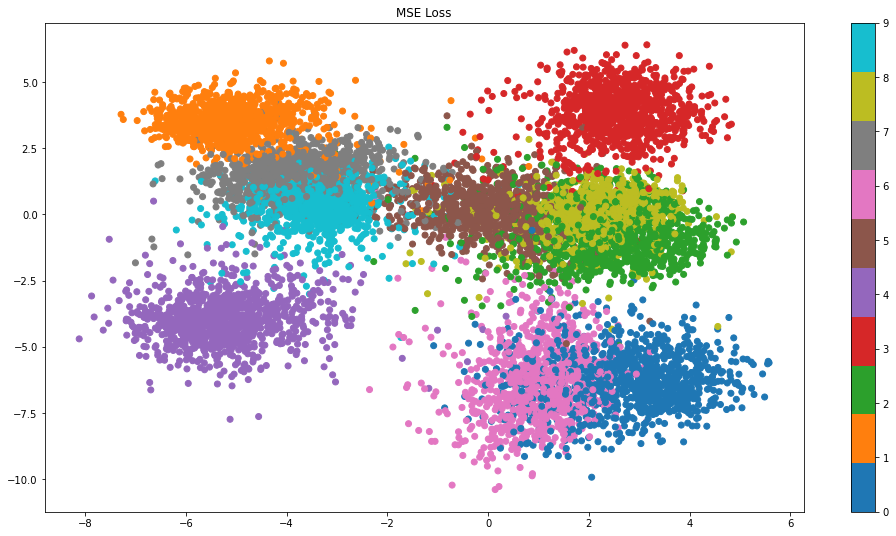

In [71]:
visualize_embeddings_2D(encoded_samples['Enc. Variable 0'], 
                        encoded_samples['Enc. Variable 1'],
                        encoded_samples.label, "MSE Loss")

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 10.7 µs


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


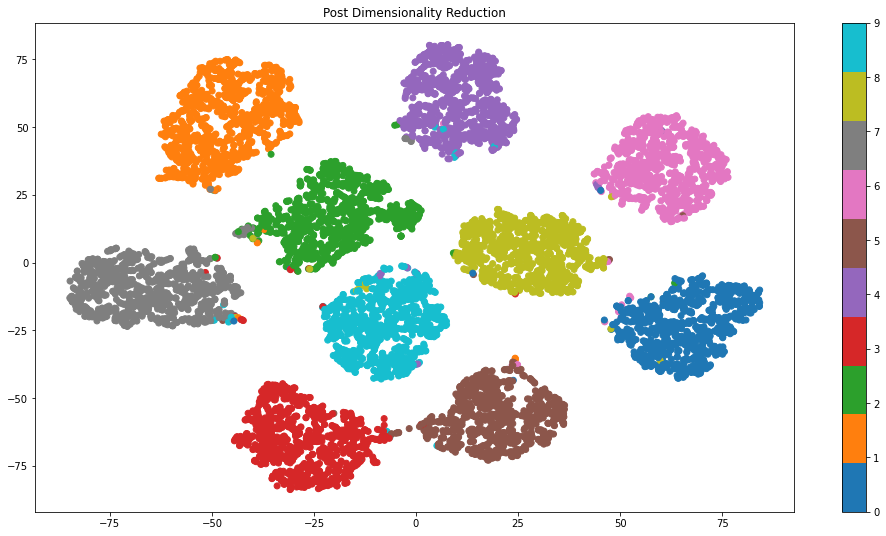

In [72]:
%time
tsne = TSNE(n_components=2,init = 'pca')
clustering_results = cluster_latent_space(tsne, encoded_samples, "Post Dimensionality Reduction")

In [73]:
clustering_results
dftsne = pd.DataFrame(clustering_results)

In [74]:
len(encoded_samples.label)
dftsne['cluster'] = encoded_samples.label

In [75]:
dftsne.head()

0          1  cluster
0 -61.505463  -7.315147        7
1 -23.497646  -0.088435        2
2 -53.734573  62.677147        1
3  50.686085 -19.589897        0
4  12.040615  54.414650        4

In [76]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
cluster_labels = kmeans.fit_predict(dftsne)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [77]:
centers = kmeans.cluster_centers_

In [78]:
kmeans = KMeans(n_clusters=10)
kmeans = fit_and_evaluate(kmeans, dftsne, dftsne['cluster'], name="KMeans with Embedding 6", n_runs=5)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

clustering done in 0.23 ± 0.03 s 
Homogeneity: 0.959 ± 0.000
Completeness: 0.959 ± 0.000
V-measure: 0.959 ± 0.000
Adjusted Rand-Index: 0.967 ± 0.000
Silhouette Coefficient: 0.610 ± 0.003


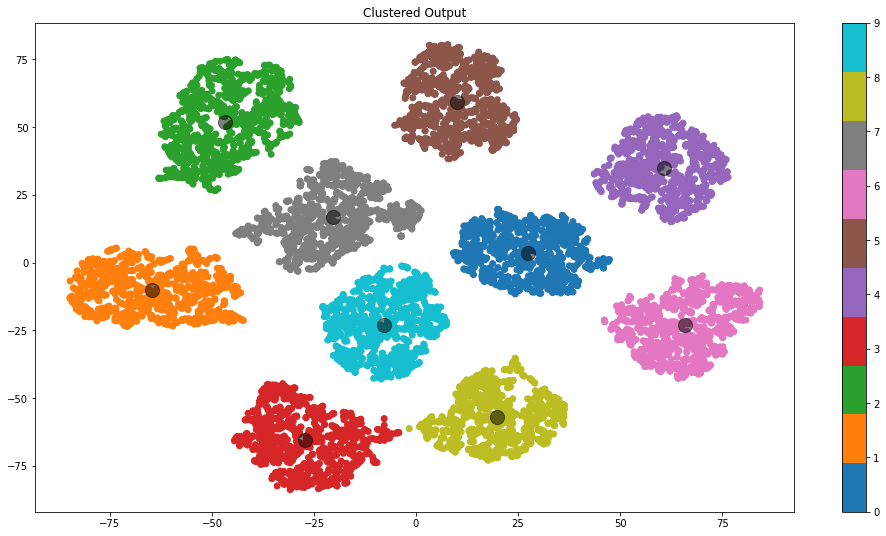

In [79]:
visualize_clustering_2D(dftsne[0],dftsne[1],cluster_labels,kmeans.cluster_centers_, "Clustered Output")

# Model 3: Autoencoder latent space embeddings 6

In [81]:
encoder = Encoder(encoded_space_dim=6,fc2_input_dim=128)
encoder = torch.jit.script(encoder).to(device)

decoder = Decoder(encoded_space_dim=6)
decoder = torch.jit.script(decoder).to(device)

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [83]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)

criterion_encoder = torch.jit.script(torch.nn.TripletMarginLoss())
criterion_decoder = torch.jit.script(torch.nn.MSELoss())

In [84]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
test_ds = Triplet_MNIST(test_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [85]:
encoder.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = {'mse':[],
                    'triplet':[]
                   }
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = encoder(anchor_img)
        positive_out = encoder(positive_img)
        negative_out = encoder(negative_img)
        
        decoded_data = decoder(anchor_out)
        loss_encoder = criterion_encoder(anchor_out, positive_out, negative_out)

        loss_decoder = criterion_decoder(decoded_data, anchor_img)
        
        
        loss = loss_encoder+loss_decoder#.backward()
        
        loss.backward()
        optimizer.step()
        
        running_loss['triplet'].append(loss.cpu().detach().numpy())
        running_loss['mse'].append(loss_decoder.cpu().detach().numpy())
    print("Epoch: {}/{} - Triplet Loss: {:.4f} - MSE Loss: {:.4f}".format(epoch+1, epochs, np.mean(np.array(running_loss['triplet'])),np.mean(np.array(running_loss['mse']))))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 1/50 - Triplet Loss: 0.3161 - MSE Loss: 0.1330


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 2/50 - Triplet Loss: 0.1050 - MSE Loss: 0.0564


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 3/50 - Triplet Loss: 0.0788 - MSE Loss: 0.0446


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 4/50 - Triplet Loss: 0.0692 - MSE Loss: 0.0405


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 5/50 - Triplet Loss: 0.0625 - MSE Loss: 0.0381


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 6/50 - Triplet Loss: 0.0573 - MSE Loss: 0.0365


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 7/50 - Triplet Loss: 0.0572 - MSE Loss: 0.0357


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 8/50 - Triplet Loss: 0.0524 - MSE Loss: 0.0342


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 9/50 - Triplet Loss: 0.0511 - MSE Loss: 0.0335


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 10/50 - Triplet Loss: 0.0476 - MSE Loss: 0.0330


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 11/50 - Triplet Loss: 0.0476 - MSE Loss: 0.0324


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 12/50 - Triplet Loss: 0.0458 - MSE Loss: 0.0318


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 13/50 - Triplet Loss: 0.0457 - MSE Loss: 0.0316


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 14/50 - Triplet Loss: 0.0438 - MSE Loss: 0.0312


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 15/50 - Triplet Loss: 0.0425 - MSE Loss: 0.0308


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 16/50 - Triplet Loss: 0.0421 - MSE Loss: 0.0305


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 17/50 - Triplet Loss: 0.0408 - MSE Loss: 0.0303


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 18/50 - Triplet Loss: 0.0419 - MSE Loss: 0.0303


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 19/50 - Triplet Loss: 0.0403 - MSE Loss: 0.0300


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 20/50 - Triplet Loss: 0.0404 - MSE Loss: 0.0298


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 21/50 - Triplet Loss: 0.0402 - MSE Loss: 0.0297


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 22/50 - Triplet Loss: 0.0394 - MSE Loss: 0.0295


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 23/50 - Triplet Loss: 0.0399 - MSE Loss: 0.0294


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 24/50 - Triplet Loss: 0.0385 - MSE Loss: 0.0293


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 25/50 - Triplet Loss: 0.0378 - MSE Loss: 0.0290


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 26/50 - Triplet Loss: 0.0369 - MSE Loss: 0.0286


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 27/50 - Triplet Loss: 0.0371 - MSE Loss: 0.0288


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 28/50 - Triplet Loss: 0.0377 - MSE Loss: 0.0286


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 29/50 - Triplet Loss: 0.0366 - MSE Loss: 0.0286


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 30/50 - Triplet Loss: 0.0363 - MSE Loss: 0.0283


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 31/50 - Triplet Loss: 0.0363 - MSE Loss: 0.0284


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 32/50 - Triplet Loss: 0.0357 - MSE Loss: 0.0283


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 33/50 - Triplet Loss: 0.0346 - MSE Loss: 0.0278


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 34/50 - Triplet Loss: 0.0356 - MSE Loss: 0.0278


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 35/50 - Triplet Loss: 0.0344 - MSE Loss: 0.0278


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 36/50 - Triplet Loss: 0.0343 - MSE Loss: 0.0276


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 37/50 - Triplet Loss: 0.0355 - MSE Loss: 0.0276


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 38/50 - Triplet Loss: 0.0353 - MSE Loss: 0.0276


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 39/50 - Triplet Loss: 0.0346 - MSE Loss: 0.0274


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 40/50 - Triplet Loss: 0.0335 - MSE Loss: 0.0273


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 41/50 - Triplet Loss: 0.0330 - MSE Loss: 0.0271


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 42/50 - Triplet Loss: 0.0333 - MSE Loss: 0.0270


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 43/50 - Triplet Loss: 0.0324 - MSE Loss: 0.0267


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 44/50 - Triplet Loss: 0.0339 - MSE Loss: 0.0270


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 45/50 - Triplet Loss: 0.0327 - MSE Loss: 0.0266


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 46/50 - Triplet Loss: 0.0329 - MSE Loss: 0.0267


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 47/50 - Triplet Loss: 0.0317 - MSE Loss: 0.0264


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 48/50 - Triplet Loss: 0.0342 - MSE Loss: 0.0268


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 49/50 - Triplet Loss: 0.0321 - MSE Loss: 0.0265


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 50/50 - Triplet Loss: 0.0328 - MSE Loss: 0.0265


In [86]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
kmeans = fit_and_evaluate(kmeans, dftsne, dftsne['cluster'], name="KMeans with Embedding 5", n_runs=5)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

clustering done in 0.24 ± 0.03 s 
Homogeneity: 0.959 ± 0.000
Completeness: 0.959 ± 0.000
V-measure: 0.959 ± 0.000
Adjusted Rand-Index: 0.967 ± 0.000
Silhouette Coefficient: 0.607 ± 0.002


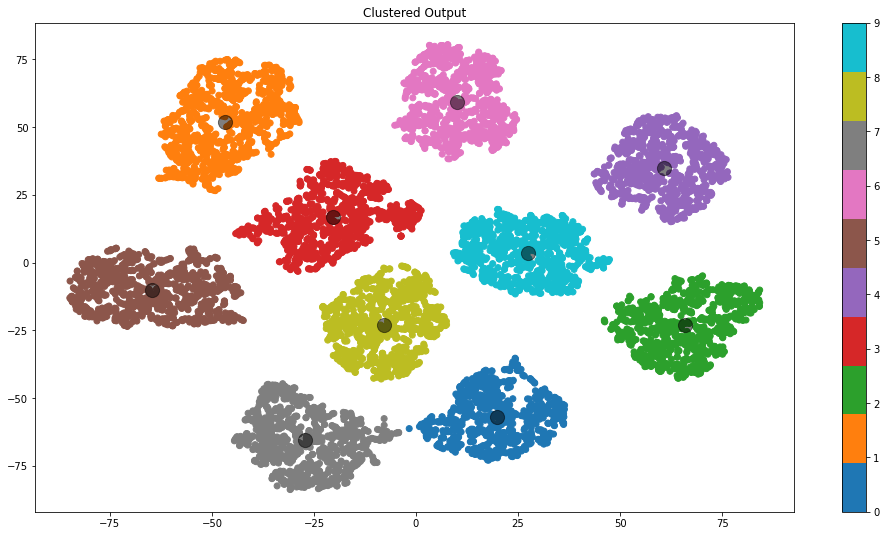

In [87]:
visualize_clustering_2D(dftsne[0],dftsne[1],kmeans.labels_,kmeans.cluster_centers_, "Clustered Output")

# Model 4: Autoencoders with latent space dimension 7

In [91]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
test_ds = Triplet_MNIST(test_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [93]:
encoder = Encoder(encoded_space_dim=7,fc2_input_dim=128)
encoder = torch.jit.script(encoder).to(device)

decoder = Decoder(encoded_space_dim=7)
decoder = torch.jit.script(decoder).to(device)

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [95]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)

criterion_encoder = torch.jit.script(torch.nn.TripletMarginLoss())
criterion_decoder = torch.jit.script(torch.nn.MSELoss())

In [96]:
encoder.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = {'mse':[],
                    'triplet':[]
                   }
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = encoder(anchor_img)
        positive_out = encoder(positive_img)
        negative_out = encoder(negative_img)
        
        decoded_data = decoder(anchor_out)
        loss_encoder = criterion_encoder(anchor_out, positive_out, negative_out)

        loss_decoder = criterion_decoder(decoded_data, anchor_img)
        
        
        loss = loss_encoder+loss_decoder#.backward()
        
        loss.backward()
        optimizer.step()
        
        running_loss['triplet'].append(loss.cpu().detach().numpy())
        running_loss['mse'].append(loss_decoder.cpu().detach().numpy())
    print("Epoch: {}/{} - Triplet Loss: {:.4f} - MSE Loss: {:.4f}".format(epoch+1, epochs, np.mean(np.array(running_loss['triplet'])),np.mean(np.array(running_loss['mse']))))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 1/50 - Triplet Loss: 0.2875 - MSE Loss: 0.0862


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 2/50 - Triplet Loss: 0.1009 - MSE Loss: 0.0546


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 3/50 - Triplet Loss: 0.0811 - MSE Loss: 0.0493


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 4/50 - Triplet Loss: 0.0703 - MSE Loss: 0.0460


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 5/50 - Triplet Loss: 0.0645 - MSE Loss: 0.0432


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 6/50 - Triplet Loss: 0.0595 - MSE Loss: 0.0407


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 7/50 - Triplet Loss: 0.0554 - MSE Loss: 0.0385


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 8/50 - Triplet Loss: 0.0514 - MSE Loss: 0.0364


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 9/50 - Triplet Loss: 0.0493 - MSE Loss: 0.0348


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 10/50 - Triplet Loss: 0.0468 - MSE Loss: 0.0334


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 11/50 - Triplet Loss: 0.0446 - MSE Loss: 0.0323


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 12/50 - Triplet Loss: 0.0427 - MSE Loss: 0.0315


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 13/50 - Triplet Loss: 0.0421 - MSE Loss: 0.0307


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 14/50 - Triplet Loss: 0.0419 - MSE Loss: 0.0300


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 15/50 - Triplet Loss: 0.0412 - MSE Loss: 0.0296


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 16/50 - Triplet Loss: 0.0389 - MSE Loss: 0.0291


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 17/50 - Triplet Loss: 0.0384 - MSE Loss: 0.0287


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 18/50 - Triplet Loss: 0.0384 - MSE Loss: 0.0283


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 19/50 - Triplet Loss: 0.0370 - MSE Loss: 0.0279


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 20/50 - Triplet Loss: 0.0358 - MSE Loss: 0.0276


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 21/50 - Triplet Loss: 0.0351 - MSE Loss: 0.0273


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 22/50 - Triplet Loss: 0.0354 - MSE Loss: 0.0270


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 23/50 - Triplet Loss: 0.0341 - MSE Loss: 0.0267


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 24/50 - Triplet Loss: 0.0345 - MSE Loss: 0.0268


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 25/50 - Triplet Loss: 0.0340 - MSE Loss: 0.0265


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 26/50 - Triplet Loss: 0.0339 - MSE Loss: 0.0262


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 27/50 - Triplet Loss: 0.0336 - MSE Loss: 0.0260


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 28/50 - Triplet Loss: 0.0341 - MSE Loss: 0.0260


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 29/50 - Triplet Loss: 0.0335 - MSE Loss: 0.0258


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 30/50 - Triplet Loss: 0.0325 - MSE Loss: 0.0255


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 31/50 - Triplet Loss: 0.0318 - MSE Loss: 0.0255


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 32/50 - Triplet Loss: 0.0326 - MSE Loss: 0.0255


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 33/50 - Triplet Loss: 0.0315 - MSE Loss: 0.0251


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 34/50 - Triplet Loss: 0.0311 - MSE Loss: 0.0249


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 35/50 - Triplet Loss: 0.0322 - MSE Loss: 0.0251


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 36/50 - Triplet Loss: 0.0300 - MSE Loss: 0.0246


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 37/50 - Triplet Loss: 0.0305 - MSE Loss: 0.0246


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 38/50 - Triplet Loss: 0.0304 - MSE Loss: 0.0246


Training:   0%|          | 0/235 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
save_model(encoder, model_name='encoder_embed7')
save_model(decoder, model_name='decoder_embed7')

In [ ]:
train_data = datasets.MNIST(root=DATA_DIR, train=True, download=True)
test_data = datasets.MNIST(root=DATA_DIR, train=False, download=True)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [ ]:
encoded_samples = generate_embeddings(encoder, test_data, device)
encoded_samples = pd.DataFrame(encoded_samples)

In [ ]:
visualize_embeddings_2D(encoded_samples['Enc. Variable 0'], 
                        encoded_samples['Enc. Variable 1'],
                        encoded_samples.label, "MSE Loss")

In [ ]:
%time
tsne = TSNE(n_components=2,init = 'pca')
clustering_results = cluster_latent_space(tsne, encoded_samples, "Post Dimensionality Reduction")

In [ ]:
clustering_results
dftsne = pd.DataFrame(clustering_results)

In [ ]:
len(encoded_samples.label)
dftsne['cluster'] = encoded_samples.label

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
kmeans = fit_and_evaluate(kmeans, dftsne.drop(['cluster'],axis=1), dftsne['cluster'], name="KMeans with Embedding 7", n_runs=5)

# Visualize Stats

In [88]:
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

In [89]:
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

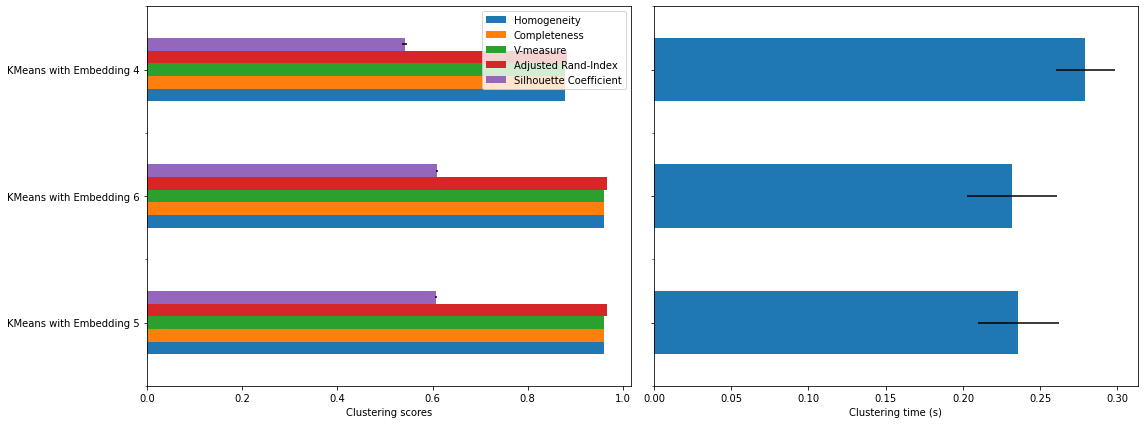

In [90]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()